<a href="https://colab.research.google.com/github/Davilirio/Neural-Nets/blob/master/gan_feature_loss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# this version of fastai uses these dependencies
!pip install "torch==1.4" "torchvision==0.5.0"

     |████████████████████████████████| 753.4MB 21kB/s 
     |████████████████████████████████| 4.0MB 51.2MB/s 
  Found existing installation: torch 1.6.0+cu101
    Uninstalling torch-1.6.0+cu101:
      Successfully uninstalled torch-1.6.0+cu101
  Found existing installation: torchvision 0.7.0+cu101
    Uninstalling torchvision-0.7.0+cu101:
      Successfully uninstalled torchvision-0.7.0+cu101


In [2]:
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from fastai.vision.gan import *
from google.colab import drive, files
from PIL import Image

drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [3]:
path = Path('/content/gdrive/My Drive/data_science_stuff/datasets/landscapes')
path_hr = path/'images'
path_lr = path/'images_bw'

In [ ]:
# # UNCOMMENT ON THE FIRST TIME RUNNING THIS NOTEBOOK

# def black_white(fn, i):
#   # setting the destiny, where the filename is relative to the true name
#   dest = path_lr/fn.relative_to(path_hr)
#   # create dir if doesnt exist
#   dest.parent.mkdir(parents=True, exist_ok=True)
#   # opening image
#   img = Image.open(fn)
#   # converting into grayscale
#   img = img.convert('L')
#   # saving in the bw destiny folder
#   img.save(dest, quality=80)

In [ ]:
# # UNCOMMENT ON THE FIRST TIME RUNNING THIS NOTEBOOK

# # create an image list to run B&W on all photos parallel
# il = ImageList.from_folder(path_hr)
# len(il.items)

In [ ]:
# # UNCOMMENT ON THE FIRST TIME RUNNING THIS NOTEBOOK

# # running the black_white func on all il.items
# parallel(black_white, il.items)

In [4]:
bs, size = 2, 512
arch = models.resnet34
wd = 1e-3
y_range = (-3.,3.)

src = ImageImageList.from_folder(path_lr).split_by_rand_pct(0.1, seed=27)

In [ ]:
# sizes of the datasets
len(src.train.items), len(src.valid.items)

(3888, 431)

In [5]:
# function to get the databunch
def create_databunch(bs,sz):
  # setting the configs of the databunch
  data = (src.label_from_func(lambda x: path_hr/x.name)
             .transform(get_transforms(max_zoom=1.75), size=sz, tfm_y=True)
             .databunch(bs=bs).normalize(imagenet_stats, do_y=True))
  return data

In [6]:
data = create_databunch(bs, size)

In [ ]:
data.c, data.show_batch()

Creating a generator with feature loss


In [7]:
def gram_matrix(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)

In [8]:
base_loss = F.l1_loss

In [9]:
from torchvision.models import vgg16_bn
vgg_m = vgg16_bn(True).features.cuda().eval()
requires_grad(vgg_m, False)

In [10]:
blocks = [i-1 for i,o in enumerate(children(vgg_m)) if isinstance(o,nn.MaxPool2d)]
# finding where the model downsamples
blocks, [vgg_m[i] for i in blocks]

([5, 12, 22, 32, 42],
 [ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True)])

In [11]:
## defining the loss_func for our generator
class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        # setting the model
        self.m_feat = m_feat
        # defining the layers from which we extract the features
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        # hooking into the layers we defined above
        self.hooks = hook_outputs(self.loss_features, detach=False)
        # saving the weights
        self.wgts = layer_wgts
        # naming the metrics used at LossMetrics
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))
              ] + [f'gram_{i}' for i in range(len(layer_ids))]

    def make_features(self, x, clone=False):
        self.m_feat(x)
        # cloning the stored features to be used in thr loss func
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        # features of the target image:
        out_feat = self.make_features(target, clone=True)
        # features of the generated images
        in_feat = self.make_features(input)
        # loss is l1 distance between target/input features
        self.feat_losses = [base_loss(input,target)]
        self.feat_losses += [base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()

In [12]:
# defining the parameters for our loss_func
feat_loss = FeatureLoss(vgg_m, blocks[2:5], [5,15,2])

Pre-training gen and critic

In [13]:
def create_gen_learner():
    return unet_learner(data, arch, wd=wd,
                        blur=True, norm_type=NormType.Weight,
                         self_attention=True, y_range=y_range,
                         loss_func=feat_loss, callback_fns=LossMetrics)

In [ ]:
learn_generator.lr_find()
learn_generator.recorder.plot()

In [ ]:
def fit_1c(learner, lr, time=1, epochs=10, pct_start=0.9):
  learner.fit_one_cycle(epochs, lr, pct_start=pct_start)
  learner.save(path/f'learner_{time}')
  learner.show_results()

In [ ]:
fit_1c(learn_generator, 1e-5, epochs=3, time = 4)

In [ ]:
learn_generator.unfreeze()
fit_1c(learn_generator, 3e-5, time=2)

In [ ]:
learn_generator.show_results(rows = 20)

In [ ]:
# saving results from the pre-trained generator:

path_gen = path/f'images_gen'

def save_predictions(dl):
  idx = 0
  names = dl.dataset.items

  for batch in dl:
    predictions = learn_generator.pred_batch(batch=batch, reconstruct = True)
    for pred in predictions:
      pred.save(path_gen/names[idx].name)
      idx+=1

In [ ]:
save_predictions(data.fix_dl)

Creating critic


In [ ]:
learn_generator = None
gc.collect()

In [18]:
def critic_databunch(classes, bs, size):
    src = ImageList.from_folder(path, include=classes).split_by_rand_pct(0.1, seed=42)
    ll = src.label_from_folder(classes=classes)
    data = (ll.transform(get_transforms(max_zoom=2.), size=size)
           .databunch(bs=bs).normalize(imagenet_stats))
    data.c = 3
    return data

/usr/local/lib/python3.6/dist-packages/fastai/data_block.py:541: UserWarning: You are labelling your items with CategoryList.
Your train set contained the following unknown labels, the corresponding items have been discarded.
landscapes
  if getattr(ds, 'warn', False): warn(ds.warn)


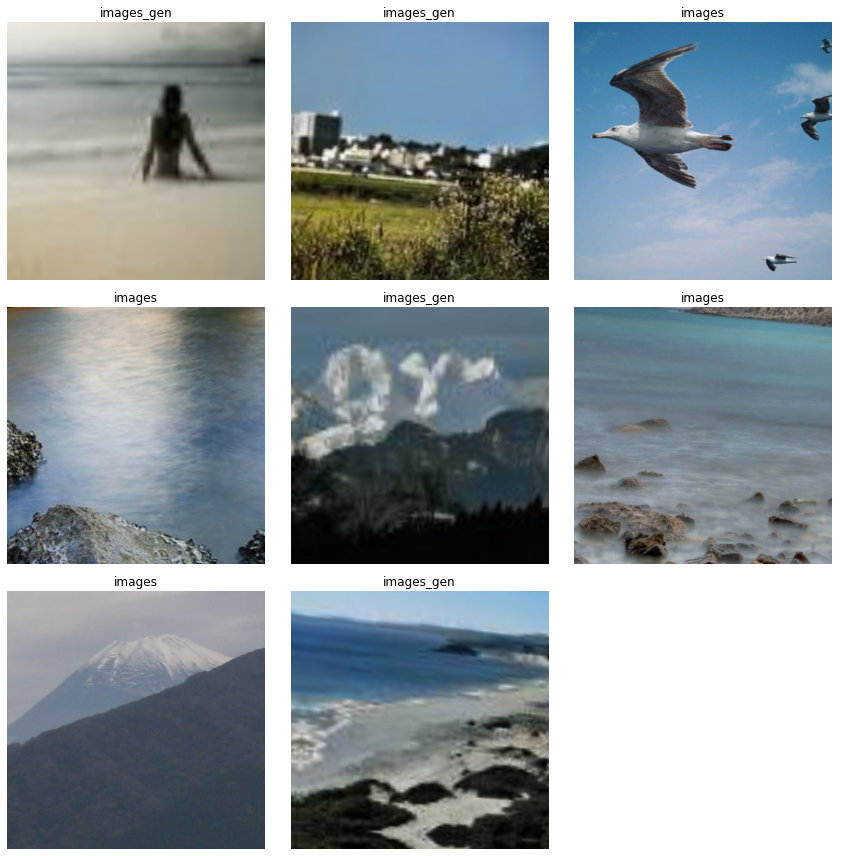

In [ ]:
data_crit = critic_databunch(['images_gen', 'images'], bs, size)
data_crit.show_batch()

In [24]:
loss_crit = AdaptiveLoss(nn.BCEWithLogitsLoss())

In [21]:
def create_critic_learner(data, metrics):
    return Learner(data, gan_critic(), metrics=metrics, loss_func=loss_crit, wd=wd)

In [ ]:
learn_critic = create_critic_learner(data_crit, accuracy_thresh_expand)

In [ ]:
learn_critic.lr_find()
learn_critic.recorder.plot()

In [ ]:
learn_critic.fit_one_cycle(10,1e-4)

In [ ]:
learn_critic.save(path/'critic_pre1')

Combining both models to create the final GAN with perceptual losses (feature loss)|

In [ ]:
learn_critic=None
learn_generator=None
gc.collect()

318

In [22]:
data_crit = critic_databunch(['images_bw', 'images'], bs=2, size=size)

/usr/local/lib/python3.6/dist-packages/fastai/data_block.py:541: UserWarning: You are labelling your items with CategoryList.
Your train set contained the following unknown labels, the corresponding items have been discarded.
landscapes
  if getattr(ds, 'warn', False): warn(ds.warn)


In [26]:
learn_crit = create_critic_learner(data_crit, metrics=None)
learn_gen = create_gen_learner()

In [27]:
switcher = partial(AdaptiveGANSwitcher, critic_thresh=0.65)
learn = GANLearner.from_learners(learn_gen, learn_crit, weights_gen=(1.,1.), show_img=True, switcher=switcher,
                                 opt_func=partial(optim.Adam, betas=(0.,0.99)), wd=wd)
learn.callback_fns.append(partial(GANDiscriminativeLR, mult_lr=5.))

In [ ]:
lr = 1e-6

In [ ]:
learn.fit(40,lr)

In [ ]:
learn.save(path/'paint_landscape_gan_2')

In [ ]:
learn.show_results(rows = 30)

Inferences

In [ ]:
learn = None
gc.collect()

42

In [28]:
learn.load(path/'landscape_color_bigger_gan');

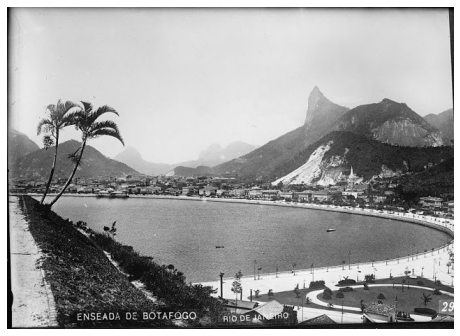

In [48]:
img = open_image(path/'rio_antigamente.jpg')
show_image(img, figsize=(8, 8))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


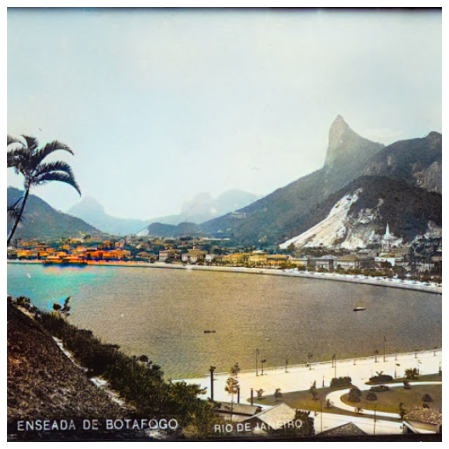

In [49]:
_, bh_c, a = learn_gen.predict(img)
show_image(bh_c, interpolation = 'bilinear', figsize = (14,8))

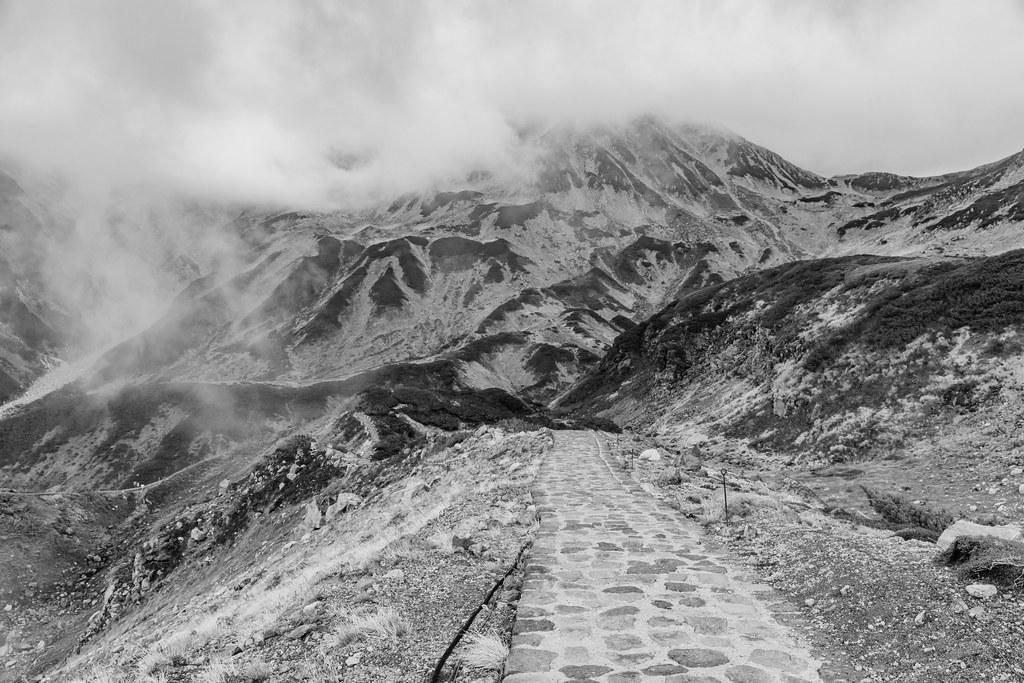

In [44]:
fn = data_crit.valid_ds.items[0]; fn
img = open_image(fn); img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


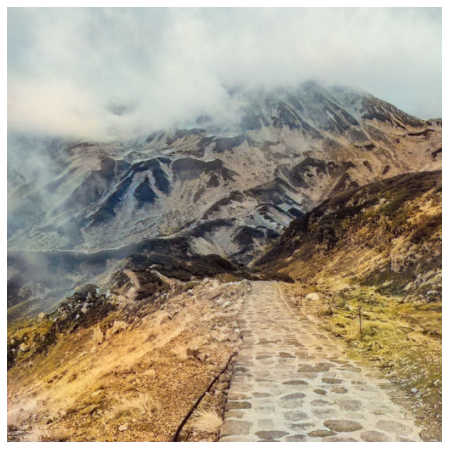

In [45]:
p,img_hr,b = learn_gen.predict(img)
show_image(img_hr, interpolation = 'bilinear', figsize = (14,8))

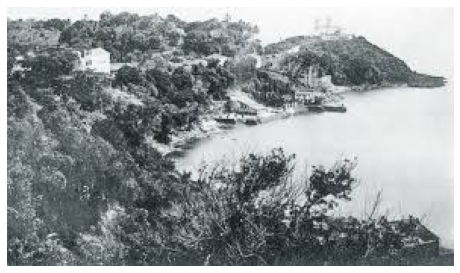

In [46]:
img = open_image(path/'bahia_antigamente.jpeg')
show_image(img, figsize=(8, 8))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


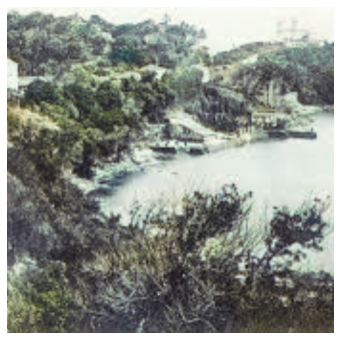

In [47]:
_, bh_c, a = learn_gen.predict(img)
show_image(bh_c, interpolation = 'bilinear', figsize = (12,6))

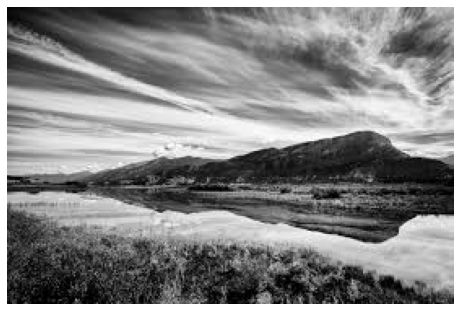

In [50]:
img_bw = open_image(path/'bw_landscape.jpeg')
show_image(img_bw, figsize=(8, 8))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


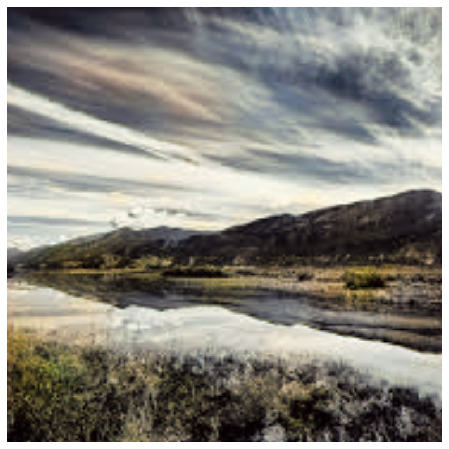

In [62]:
_, ls_bw, a = learn_gen.predict(img_bw)
show_image(ls_bw, figsize=(8, 8), interpolation='nearest')